# Classificador de notícias

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
from lxml import etree as et

#Imports nltk ---------------------------------------------
import nltk
from nltk.stem.snowball import SnowballStemmer

#Imports sklearn ------------------------------------------

#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#regressão logística
from sklearn.linear_model import LogisticRegression

#knn
from sklearn.neighbors import KNeighborsClassifier

### Importando stopwords e stemmer

In [2]:
stemmer = SnowballStemmer('portuguese')
stopwords = nltk.corpus.stopwords.words('portuguese')

### Importando notícias

Total de notícias: 2109
Noticias para classificação: 1958


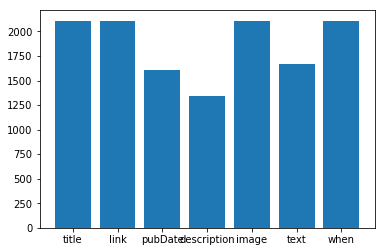

title: 2109 ocorrências
link: 2109 ocorrências
pubDate: 1610 ocorrências
description: 1341 ocorrências
image: 2109 ocorrências
text: 1667 ocorrências
when: 2109 ocorrências


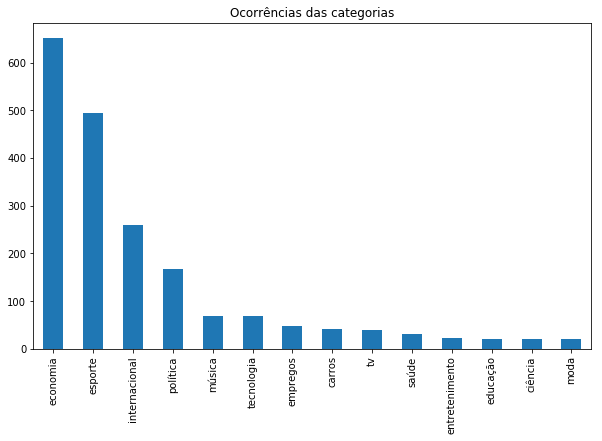

In [3]:
parser = et.XMLParser(recover=True)
data = et.parse("news_data.xml", parser=parser).getroot()

tags = ["title","link","pubDate","description","image","text","when"]
hist = {}
for t in tags:
    hist[t] = 0;
    
items = data.findall("item")
total = len(items)
news = []
labels = []

for c in items:
    aux = ""
    text = c.find("text").text
    desc = c.find("description").text
    if not text == None:
        aux += text
    if not desc == None:
        aux += desc
    if aux!="":
        news.append(aux)
        labels.append(c.get("category"))
        
    for t in tags:
        if c.find(t).text != None:
            hist[t] += 1

print("Total de notícias: {}".format(total))
print("Noticias para classificação: {}".format(len(news)))

plt.bar(range(len(hist)),hist.values(),align='center')
plt.xticks(range(len(hist)),hist.keys())
plt.show()

df = pd.DataFrame({"category":labels})
fig = plt.figure(figsize=(10,6))
plt.title("Ocorrências das categorias")
df["category"].value_counts().plot(kind="bar")

for k in hist.keys():
    print("{}: {} ocorrências".format(k,hist[k]))

## Análise dos atributos das notícias

Através do histograma acima, podemos analizar que todas as notícias possuem data(when), link, imagem e título.

* Imagem e link não são interpretáveis para o nosso problema, logo não compensa que coloquemos estes atributos em nosso classificador;
* Data(when) e data de publicação, embora sejam interpretáveis, é provável que não acrescentem nenhuma informação relevante para nossa classificação;
* Texto, título e descrição podem ser bastante úteis em nosso problema, embora o título, devido a sua natureza mais interativa para chamar a atenção, possa atrapalhar nos cálculos, portanto, colocaremos ele de fora da classificação.

## Iniciando pré-processamento

### Processando notícias

In [4]:
news[0]

'A rodada deste fim de semana ainda não confirmou o título do Corinthians, que segue com mais de 99% de chance de conquista, contra menos de 1% do Atlético Mineiro segundo o site Infobola, do matemático Tristão Garcia. Para o Galo, o triunfo sofre o Figueirense, com um gol no finzinho, além de manter a chance matemática de título para os mineiros, também confirmou o time com uma das vagas para a Libertadores. Para as vagas que restam para a competição sul-americana, o Grêmio, embora derrotado pelo Sport, segue bem tranquilo. Só uma catástrofe tira o time gaúcho da vaga 3 e por isso suas chances estão em 96%. Daí para a frente, a coisa embola um pouco. A rodada fez o leque de possibilidades se ampliar. Um exemplo é que o Flamengo saiu do traço e voltou a ter uma pequena chance após a sua vitória e os resultados dos rivais. Afinal, quem estava bem à frente não venceu. Santos, São Paulo e Internacional seguem bem cotados. O Sport (que tem uma tabela bem complicada e por isso está com apen

In [5]:
#Removendo stopwords,"tokenizando", aplicando stemmer e removendo caracteres indesejáveis
undesired = [',','.',"'",'"','´',';',':','-','?','!','%','(',')','\t','\n']
data_processed = []
for k in news:
    tokenizedText = nltk.word_tokenize(k,language='portuguese')
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords and not t in undesired]
    data_processed.append(stemmedText)

In [6]:
#Reescrevendo noticias
new_data = []
for data in data_processed:
    new_data.append(" ".join(data))

data_processed = new_data

data_processed[0]

'a rod dest fim seman aind confirm títul corinthians seg 99 chanc conquist contr men 1 atlét mineir segund sit infobol matemát tristã garc par gal triunf sofr figueirens gol finzinh além mant chanc matemát títul mineir confirm tim vag libert par vag rest competiçã sul-american grêmi embor derrot sport seg bem tranquil só catástrof tir tim gaúch vag 3 chanc 96 daí frent cois embol pouc a rod fez lequ possibil ampli um exempl é flameng saiu trac volt ter pequen chanc após vitór result riv afinal bem frent venc sant sã paul internacional segu bem cot o sport tabel bem complic apen 7 precis bom result próxim rod aproxim trinc pont pret palmeir cruzeir rubro-negr resp grac bom númer vitór dar vantag cas empat pont contr qualqu dem concorrent resp aparelh na turm tent escap degol vasc seg constru notável reaçã embor aind aparec 84 possibil rebaix cruz-maltin consegu result pouc esper vitór sobr palmeir cas pod dar supersalt rum salvaçã próxim rod ocorr dois jog riv diret rebaix goiás x corit

## Iniciando classificação

### Preparando dados para classificação

In [7]:
#Permutação dos dados
temp = np.column_stack((data_processed,labels))
temp = np.random.permutation(temp)
data_processed = temp[:,0]
labels = temp[:,1]

### Gerando matrizes dos dados

In [8]:
cv = CountVectorizer()

X_counts = cv.fit_transform(data_processed)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_counts)
text_tf = tf_transformer.transform(X_counts)

### Separando features de treino e teste

In [9]:
#Separação das labels de treino e teste
p = 0.8
size = len(data_processed)
partition = math.floor(size*p)

trainLabels = labels[:partition]
trainText = text_tf[:partition]

testText = text_tf[partition:]
testLabels = labels[partition:]

### Classificando

In [10]:
clf_multinomial = MultinomialNB().fit(trainText, trainLabels)
print("Multinomial: {0:.2f}% de precisão".format(clf_multinomial.score(testText,testLabels)*100))

clf_gaussian = GaussianNB().fit(trainText.toarray(), trainLabels)
print("Gaussian: {0:.2f}% de precisão".format(clf_gaussian.score(testText.toarray(),testLabels)*100))

clf_bernouli = BernoulliNB().fit(trainText.toarray(), trainLabels)
print("Bernoulli: {0:.2f}% de precisão".format(clf_bernouli.score(testText.toarray(),testLabels)*100))

clf_logistic = LogisticRegression().fit(trainText.toarray(), trainLabels)
print("Regressão: {0:.2f}% de precisão".format(clf_logistic.score(testText.toarray(),testLabels)*100))

clf_knn = KNeighborsClassifier(n_neighbors=7).fit(trainText.toarray(), trainLabels)
print("KNN: {0:.2f}% de precisão".format(clf_knn.score(testText.toarray(),testLabels)*100))

Multinomial: 59.44% de precisão
Gaussian: 73.47% de precisão
Bernoulli: 69.64% de precisão
Regressão: 71.68% de precisão
KNN: 76.02% de precisão


In [11]:
def process_new(new):
    tokenizedText = nltk.word_tokenize(new)
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords]

    text = [word for word in stemmedText if not word in undesired]
    text = " ".join(text)
    cv_text = cv.transform([text])
    
    return tf_transformer.transform(cv_text)

def classify_new(new):
    processed_new = process_new(new)
    
    print("Multinomial: {}".format(clf_multinomial.predict(processed_new)))
    print("Bernouli: {}".format(clf_bernouli.predict(processed_new)))
    print("Gaussian: {}".format(clf_gaussian.predict(processed_new.toarray())))
    print("Logistic: {}".format(clf_logistic.predict(processed_new.toarray())))
    print("KNN: {}".format(clf_knn.predict(processed_new.toarray())))

### Teste com uma notícia

In [12]:
new = "A rodada deste fim de semana ainda não confirmou o título do Corinthians, que segue com mais de 99% de chance de conquista, contra menos de 1% do Atlético Mineiro segundo o site Infobola, do matemático Tristão Garcia. Para o Galo, o triunfo sofre o Figueirense, com um gol no finzinho, além de manter a chance matemática de título para os mineiros, também confirmou o time com uma das vagas para a Libertadores. Para as vagas que restam para a competição sul-americana, o Grêmio, embora derrotado pelo Sport, segue bem tranquilo. Só uma catástrofe tira o time gaúcho da vaga 3 e por isso suas chances estão em 96%. Daí para a frente, a coisa embola um pouco. A rodada fez o leque de possibilidades se ampliar. Um exemplo é que o Flamengo saiu do traço e voltou a ter uma pequena chance após a sua vitória e os resultados dos rivais. Afinal, quem estava bem à frente não venceu. Santos, São Paulo e Internacional seguem bem cotados. O Sport (que tem uma tabela bem complicada e por isso está com apenas 7%) precisa de mais um bom resultado na próxima rodada para se aproximar da trinca. Ponte Preta, Palmeiras, Cruzeiro e o Rubro-Negro (que respira graças ao seu bom número de vitórias que lhe dará vantagem caso empate em pontos contra qualquer um dos demais concorrentes) respiram por aparelho. Na turma que tenta escapar da degola, o Vasco segue construindo notável reação. Embora ainda apareça com 84% de possibilidade de rebaixamento, o Cruz-Maltino conseguiu resultado pouco esperado, a vitória sobre o Palmeiras fora de casa, e pode dar um supersalto rumo à salvação já na próxima rodada quando ocorrem dois jogos de rivais diretos pelo rebaixamento: Goiás x Coritiba e Avaí x Joinville. Olho vivo no Figueirense. A série de resultados ruins fez o time encostar muito no bolo dos desesperados. Já a Chapecoense, com a vitória sobre o Fluminense, se despediu dessa briga."

classify_new(new)

Multinomial: ['esporte']
Bernouli: ['esporte']
Gaussian: ['esporte']
Logistic: ['esporte']
KNN: ['esporte']


### Quem sabe faz ao vivo!

In [19]:
new = """
Raí chamou a responsabilidade pelo momento ruim do São Paulo no Campeonato Brasileiro. Em entrevista concedita nesta terça-feira, no CT, o diretor executivo de futebol apoiou o técnico Diego Aguirre, disse que uma eventual demissão sequer está em pauta e pediu para a torcida continuar acreditando na equipe.

O São Paulo era o líder do Brasileirão no fim do primeiro turno, mas terminou a 29ª rodada na quarta posição, com 52 pontos, sete atrás do Palmeiras, atual primeiro colocado.

– Sobre o trabalho do Aguirre, o resultado fala. Não o resultado imediato, mas desde que ele chegou aqui. Onde pegou o time, como estava e onde chegou. Isso não está nem em pauta. Acreditamos no trabalho dele, no trabalho do grupo. É o treinador que soube mexer com esse grupo várias vezes, não só quando chegou, outras vezes, para fazer o time melhor. Em um momento ruim, normal em uma temporada, ele e sua comissão vão saber como mexer com o grupo – disse Raí.

Raí é o executivo de futebol do São Paulo — Foto: Rubens Chiri/saopaulofc.net Raí é o executivo de futebol do São Paulo — Foto: Rubens Chiri/saopaulofc.net

A renovação de contrato de Aguirre, por outro lado, é um assunto a ser discutido no fim do ano. Há alguns meses, durante a boa fase no Brasileirão, o São Paulo procurou o treinador, pois queria iniciar a negociação para aumentar o vínculo válido até dezembro. O uruguaio preferiu adiar a conversa.

Agora, com o time em baixa, a negociação também não será realizada. A avaliação do São Paulo é de que não se pode adotar extremos: nem na fase boa Aguirre era gênio e agora na fase ruim também não é o pior treinador do mundo. De qualquer maneira, o Tricolor não terá a concorrência da seleção uruguaia, pois Óscar Tabárez renovou com a Celeste.

Raí não apontou um único motivo para explicar a queda de rendimento do São Paulo no Brasileirão. Internamente, o desfalque de Everton, com estiramento na coxa esquerda, é citado como uma das principais razões.

– No momento desafiador, e já passei por vários na minha carreira como jogador e estou passando por um agora, você tem de pensar em todos os detalhes. Quando as coisas estão dando certo, tudo sai mais fácil. Quando não estão dando certo, tem de pensar em todos os detalhes e cada um melhorar um pouco mais: os jogadores, a comissão técnica, a diretoria. Eu sou o maior responsável disso, da situação hoje em dia, e continuo confiante. Melhorando o trabalho, o que você acha que pode melhorar, vai recuperando a confiança. Com os resultados, as coisas voltam ao normal – afirmou.

O executivo do São Paulo também descartou um possível racha no elenco ou uma eventual perda de comando de Aguirre no vestiário.

– Este é um dos melhores grupos com que eu já trabalhei, em ambiente de grupo, e todo mundo festejou isso quando a gente estava bem, na liderança. O grupo é bom e continua bom. Isso não está em pauta, porque a gente confia no grupo. Com alguns maus resultados e atuações não tão boas, a confiança foi atingida, e a gente precisa recupera isso, trabalhando aqui dentro e contando com a colaboração da torcida. O time chegou a um estágio muito bom de rendimento, resultado, chegou a ser líder... Só peço que a torcida continue acreditando que vamos terminar o campeonato em uma boa colocação – completou Raí.

No próximo sábado, às 19h (de Brasília), o São Paulo recebe o Atlético-PR no Morumbi.
"""

classify_new(new)

Multinomial: ['economia']
Bernouli: ['economia']
Gaussian: ['economia']
Logistic: ['economia']
KNN: ['economia']
